# Aprendizado De Máquina
## Trabalho Prático 1
### Nome: Otávio Augusto Silva
### Matrícula: 2016006808

In [1]:
import numpy
import pandas
import xgboost
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from matplotlib import pyplot
from sklearn import naive_bayes
from sklearn import model_selection

# Introdução
<p>Neste trabalho prático vamos realizar um experimento de predição binária (a resposta é sim ou não) utilizando como base de dados um arquivo <em>.csv</em> contendo informações sobre <em>Kepler Object of Interest</em> (KOI) onde alguns são de fato exoplanetas (confirmado) e outros não são (falsos positivos). O objetivo será portanto, dado as <em>features</em> de exoplanetas reais e de diversos tipos de falsos positivos, ser capaz de predizer se determinado KOI é exoplaneta ou não.</p><p>O experimento consiste em comparar os seguintes métodos de aprendizado:<ul>
    <li><strong>Naive Bayes</strong></li>
    <li><strong>Árvores De Decisão</strong></li>
    <li><strong>SVM</strong></li>
    <li><strong>k-NN</strong></li>
    <li><strong>Random Forest</strong></li>
    <li><strong>Gradient Tree Boosting</strong></li>
</ul>Variando seus respectivos hiperparâmetros e comparando seus resultados.</p>

# Análise Dos Dados

<p>Como descrito anteriormente, a base de dados utilizada é um arquivo <em>.csv</em> contendo dados organizados em uma tabela.</p>

In [2]:
df = pandas.read_csv("koi_data.csv")
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [3]:
print("Linhas:", df.shape[0])
print("Colunas:", df.shape[1])

Linhas: 5202
Colunas: 43


<p>Antes de começar o treinamento e avaliação dos modelos, primeiro é preciso fazer uma análise dos dados disponíveis, assim como separar os dados de treino e teste para a o processo de validação cruzada.</p><p>Como é possível observar, a base de dados possui os seguintes características:<ul>
    <li>A base possui um total de 5202 itens</li>
    <li>Todas as colunas com exceção de <em>kepoi_name</em> e <em>koi_disposition</em> possui valores numéricos não-normalizados</li>
    <li>A coluna <em>koi_disposition</em> nos dá a classificação de cada item de forma não-numérica</li>
    <li>Cada item possui 41 <em>features</em> que podem ser utilizadas</li>
</ul>Com isso, é necessário antes de tudo abandonar a <em>feature</em> não-numérica (como ela apenas representa o nome dos objetos, isso não afetará o processo de aprendizado), normalizar os dados e mudar a coluna <em>koi_disposition</em> para valores numéricos. Como estamos lidando com um problema de classificação onde as classes são exoplaneta e não-exoplaneta, podemos simplesmente atribuir valores 0 e 1. A normalização utilizada é <em>Z-Score</em>, que consiste em normalizar os dados  a partir da média e do desvio-padrão do conjunto. A fórmula é dada por:<p>$$z_i = \frac{x_i - \mu}{\sigma}$$</p>Onde $z_i$ é o dado normalizado, $x_i$ é o dado original no conjunto, $\mu$ é a média e $\sigma$ o desvio-padrão dos dados.</p>

In [4]:
df = df.drop("kepoi_name", axis=1)
df["koi_disposition"] = df["koi_disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0)
column_names = [i for i in df]
for i in column_names[1:]:
    df[i] = (df[i] - numpy.mean(df[i])) / numpy.std(df[i])
df.head()

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,-0.311553,-0.217320,-0.380571,-0.309398,-0.082315,-0.008254,-0.029726,-0.301305,0.519927,...,0.071571,0.118428,0.000962,-0.012756,0.016120,0.104656,-0.549766,0.048036,0.149476,-0.509227
1,1,0.196655,-0.049889,-0.158005,-0.305531,-0.080146,-0.015587,-0.029572,0.476709,0.514408,...,-0.024989,0.138102,0.014051,-0.019207,0.178363,0.031830,-0.489396,0.214374,0.079993,-0.451947
2,0,-0.399225,0.212673,-0.459729,-0.197976,0.058850,-0.127127,-0.021293,-0.543685,-0.864118,...,0.022289,0.054791,0.049972,-0.023980,-0.080820,0.085357,-0.521487,-0.088686,0.072313,-0.523229
3,1,-0.390305,-0.006129,-0.567731,-0.309585,-0.081650,-0.056867,-0.029594,-0.499428,0.259307,...,0.031490,0.070260,0.005224,-0.006563,0.032344,-0.000942,-0.581540,0.043979,0.043423,-0.588782
4,0,-0.335603,0.171957,-0.084032,-0.315102,-0.020037,-0.135721,-0.019738,-0.314955,-1.242477,...,-1.192819,1.688978,0.050124,-0.077263,-1.807495,2.839274,2.224084,-1.825095,2.856766,2.236391


<p>E assim a base de dados possui agora apenas <em>features</em> numéricas normalizadas.</p><p>O nosso objetivo é a coluna <em>koi_disposition</em>, ou seja, é o vetor $Y$ que os algoritmos de aprendizado devem ser capazes de apresentar como resultado da classificação. Com isso podemos separar nossos dados.</p>

In [5]:
x = df[column_names[1:]]
y = df[column_names[0]]
(df[column_names[0]].value_counts()/len(df)*100).round(2).to_frame(column_names[0] + " (%)").T

koi_disposition,0,1
koi_disposition (%),59.55,40.45


<p>Como visto acima, temos uma proporção de aproximadamente 60/40 nos casos positivo e negativo do conjunto de dados.</p>

# K-Fold

<p>Para avaliar o quão bem os modelos conseguem generalizar o problema, será feita a validação cruzada utilizando a técnica do <em>K-Fold</em>. Essa técnica consiste em criar 5 subconjuntos aleatoriamente a partir dos dados, e a cada iteração fixar um conjunto como teste e os outros como treino, e nas seguintes alternar os conjuntos.</p>

In [6]:
sets = list(model_selection.KFold(5, shuffle=True).split(df))

<p>A variável <em>sets</em> guarda as 5 iterações do nosso <em>K-Fold</em>, onde cada um dos elementos no conjunto do <em>fold</em> são os índices das linhas do nosso conjunto de dados que determina o treino e o teste de cada iteração.</p><p>Assim, vamos definir uma função para fazer a validação cruzada dos nossos modelos.</p>

In [7]:
def cross_validation(model, sets, x, y, p):
    l1 = []
    l2 = []
    for train_set, test_set in sets:
        x_train, y_train = x.iloc[train_set], y.iloc[train_set]
        x_test, y_test = x.iloc[test_set], y.iloc[test_set]
        l = model(x_train, y_train, x_test, y_test, p)
        l1.append(l[0])
        l2.append(l[1])
    return l1, l2

<p>A função <em>cross_validation</em> recebe um modelo, o cunjunto gerado pelo <em>K-Fold</em> para testes e treinos, o conjunto $X$ de <em>features</em>, o cunjunto $Y$ contendo o nosso <em>target</em> e o hiperparâmetro do modelo em questão.</p><p>Ao final das 5 iterações, será retornado duas listas com as acurácias nos treinos e nos testes (<em>l1</em> e <em>l2</em>).</p>

# Naive Bayes

<p>Para servir de <em>baseline</em> deste trabalho prático, será usado o algoritmo <em>Naive Bayes</em>, que é um método de aprendizado probabilístico que assume que as <em>features</em> dos dados são independentes entre si.</p>

In [8]:
def gaussian_naive_bayes(x_train, y_train, x_test, y_test, p):
    gnv = naive_bayes.GaussianNB()
    gnv.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, gnv.predict(x_train)), metrics.accuracy_score(y_test, gnv.predict(x_test)))

<p>Como não há hiperparâmetros, será feito a validação cruzada apenas uma vez.</p>

In [9]:
g1, g2 = cross_validation(gaussian_naive_bayes, sets, x, y, None)
pandas.DataFrame({"Média": [numpy.mean(g1), numpy.mean(g2)], "Variância": [numpy.var(g1), numpy.var(g2)]}, index=["Treino", "Teste"])

,Média,Variância
Treino,0.916763,0.000007
Teste,0.916957,0.000037


<p>Como observado, o modelo apresentou médias de teste e treino extremamente próximas e variâncias baixas nos dois casos, o que indica que houve boa generalização do problema a ser resolvido.</p>

# Árvores De Decisão

<p>O primeiro modelo a ser avaliado será uma árvore de decisão, que cosiste em avaliar os dados estabelecendo partições criando formas de divisão a cada vértice e criando classificações nas folhas da árvore ao final do processo. O hiperparâmetro a ser buscado será a profundidade da árvore, onde uma árvore pouco profunda acaba não sendo suficiente para a complecidade dos dados (<em>undefitting</em>) e uma árvore muito profunda acaba sendo complexa demais e decora seus dados de treino (<em>overfitting</em>), onde nos dois casos não há boa generalização.</p>

In [10]:
def decision_tree(x_train, y_train, x_test, y_test, p):
    t = tree.DecisionTreeClassifier(max_depth=p)
    t.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, t.predict(x_train)), metrics.accuracy_score(y_test, t.predict(x_test)))

In [11]:
t1_mean, t1_var, t2_mean, t2_var = [], [], [], []
for i in range(1, 31):
    a1, a2 = cross_validation(decision_tree, sets, x, y, i)
    t1_mean.append(numpy.mean(a1))
    t1_var.append(numpy.var(a1))
    t2_mean.append(numpy.mean(a2))
    t2_var.append(numpy.var(a2))

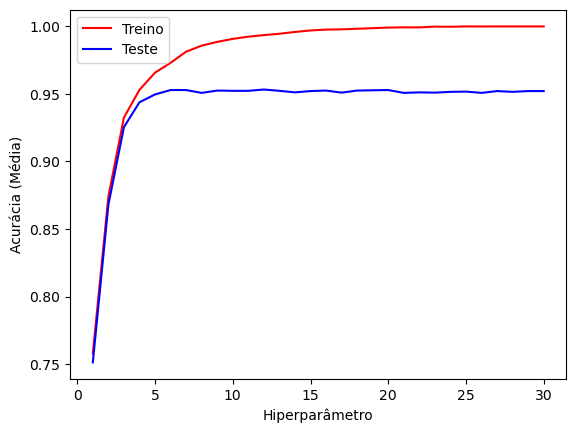

In [12]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Média)")
pyplot.plot(numpy.arange(1, 31, 1), t1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 31, 1), t2_mean, "b-", label="Teste")
pyplot.legend()
pyplot.show()

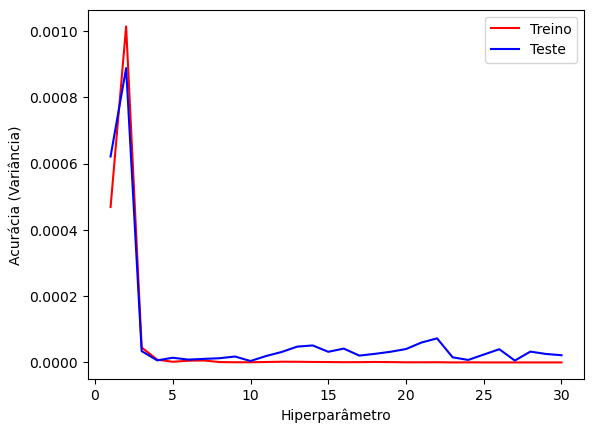

In [13]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Variância)")
pyplot.plot(numpy.arange(1, 31, 1), t1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 31, 1), t2_var, "b-", label="Teste")
pyplot.legend()
pyplot.show()

<p>Como é possível perceber graficamente, as médias das acurácias de treino e de teste caminham juntamente para valores de <em>k</em> entre 1 e 3 com alta variância, e depois começam a se afastar, onde as taxas no treino se aproximam de 100% e os valores de teste se mantém próximos de 95% com baixa variância, o que indica que o modelo está decorando os dados de treino, os seja, <em>overfitting</em>.</p><p>O valor ideal do hiperparâmetro <em>k</em> portanto seria algo próximo de 5, onde o modelo ainda não decorou os dados de treino mas apresenta bons resultados no teste.</p>

# Support Vector Machine

<p>O segundo modelo a ser avaliado é o algoritmo SVM (<em>support vector machine</em>), que consiste em encontrar uma classificação linear no conjunto de dados tal que a mesma possua a maior margem possível (maximiza a distância entre os subconjuntos definidos pelas classificações) aplicando uma transformação da dimensionalidade dos dados utilizando uma função especial chamada <em>kernel</em>, que assim permite o algoritmo operar em dados que não são linearmente separáveis.</p><p>O hiperparâmetro então será justamente a função utilizada no <em>kernel</em>, aqui vamos considerar as funções:<ul>
    <li>Linear</li>
    <li>Sigmóide</li>
    <li>Polinomial</li>
    <li>Função de Base Radial (RBF)</li>
    </ul></p>

In [14]:
def support_vector_machines(x_train, y_train, x_test, y_test, p):
    svm_ = svm.SVC(gamma="scale", kernel=p)
    svm_.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, svm_.predict(x_train)), metrics.accuracy_score(y_test, svm_.predict(x_test)))

In [15]:
s1_mean, s1_var, s2_mean, s2_var = [], [], [], []
for i in ["linear", "poly", "rbf", "sigmoid"]:
    a1, a2 = cross_validation(support_vector_machines, sets, x, y, i)
    s1_mean.append(numpy.mean(a1))
    s1_var.append(numpy.var(a1))
    s2_mean.append(numpy.mean(a2))
    s2_var.append(numpy.var(a2))

In [16]:
pandas.DataFrame({"Treino (Média)": s1_mean, "Treino (Variância)": s1_var, "Teste (Média)": s2_mean, "Teste (Variância)": s2_var}, index=["Linear", "Sigmóide", "Polinomial", "RBF"])

,Treino (Média),Treino (Variância),Teste (Média),Teste (Variância)
Linear,0.954825,0.000002,0.952136,0.000052
Sigmóide,0.891100,0.000020,0.878317,0.000025
Polinomial,0.942474,0.000002,0.935025,0.000043
RBF,0.832564,0.000082,0.839676,0.000178


<p>Como é possível observar pelos dados, o <em>kernel</em> linear obteve os melhores resultados, com médias de treino e teste próximos de 95% de acurácia e com a menor variância nos resultados da validação cruzada, e o <em>RBF</em> obteve os piores em termos de média.</p>

# k-Nearest Neighbours

<p>O terceiro modelo a ser avaliado é o algoritmo k-NN (<em>k-Nearest Neighbours</em>) que consiste em observar as classes dos <em>k</em> vizinhos mais próximos de um item para gerar classificações através de vetores de <em>features</em> em um espaço euclidiano. Intuitivamente, o hiperparâmetro a ser testado é justamente o número de vizinhos.</p>

In [17]:
def k_nearest_neighbours(x_train, y_train, x_test, y_test, p):
    knn = neighbors.KNeighborsClassifier(n_neighbors=p)
    knn.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, knn.predict(x_train)), metrics.accuracy_score(y_test, knn.predict(x_test)))

In [18]:
k1_mean, k1_var, k2_mean, k2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(k_nearest_neighbours, sets, x, y, i)
    k1_mean.append(numpy.mean(a1))
    k1_var.append(numpy.var(a1))
    k2_mean.append(numpy.mean(a2))
    k2_var.append(numpy.var(a2))

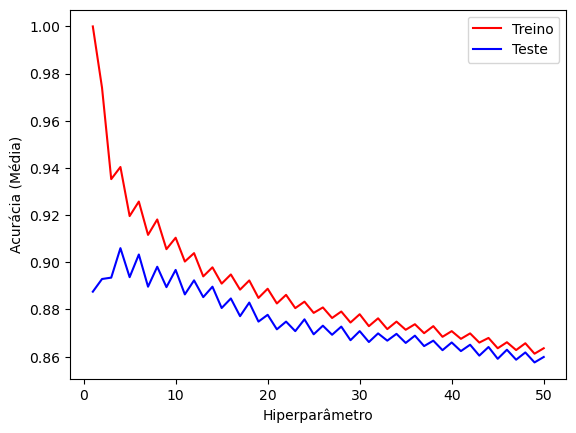

In [19]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Média)")
pyplot.plot(numpy.arange(1, 51, 1), k1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), k2_mean, "b-", label="Teste")
pyplot.legend()
pyplot.show()

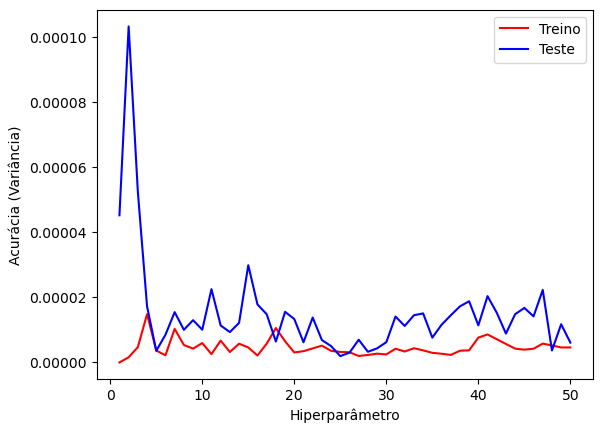

In [20]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Variância)")
pyplot.plot(numpy.arange(1, 51, 1), k1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), k2_var, "b-", label="Teste")
pyplot.legend()
pyplot.show()

<p>Como é possível observar graficamente, quanto menor o número de vizinhos utilizados, maior é a distância entre as médias das acurácias entre o treino e o teste, o que indica que o algoritmo está entrando em <em>overfitting</em> decorando os dados de treino (com apenas um vizinho a média das acurácias se torna 100%). Ainda sim, com menos vizinhos o modelo apresenta acurácias melhores, tanto que quanto mais vizinhos mais próximas as curvas de treino e teste estão mas a acurácia geral decresce. Um valor ideal de vizinhos seria próximo de 5, onde as curvas começam a se aproximar eas médias das acurácias ainda apresentam bons valores. A variância em treino se manteve próxima de 0, mas em teste o modelo apresentou variâncias maiores.</p>

# Random Forest

<p>O quarto modelo a ser avaliado é o algoritmo <em>Random Forest</em>, que é uma técnica de <em>bootstrap aggregating</em> (também conhecida como <em>bagging</em>) que consiste em gerar múltiplas árvores de decisão, coletar amostras aleatórias do conjunto de dados e treinar as árvores usando essas amostras, e então pegar o resultado mais frequente ao classificar um determinado item. Essa técnica tem como foco evitar a tendência das árvores de decisão de entrar em estado de <em>overfitting</em> decorando os dados de treino e controlar a variância dos resultados.</p>

In [21]:
def random_forest(x_train, y_train, x_test, y_test, p):
    rf = ensemble.RandomForestClassifier(max_depth=5, n_estimators=p)
    rf.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, rf.predict(x_train)), metrics.accuracy_score(y_test, rf.predict(x_test)))

In [22]:
rf1_mean, rf1_var, rf2_mean, rf2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(random_forest, sets, x, y, i)
    rf1_mean.append(numpy.mean(a1))
    rf1_var.append(numpy.var(a1))
    rf2_mean.append(numpy.mean(a2))
    rf2_var.append(numpy.var(a2))

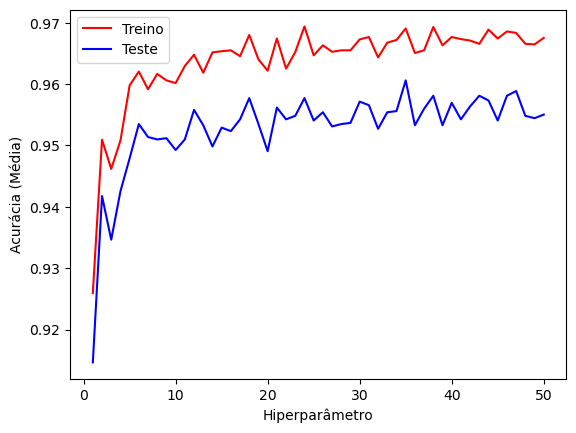

In [23]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Média)")
pyplot.plot(numpy.arange(1, 51, 1), rf1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), rf2_mean, "b-", label="Teste")
pyplot.legend()
pyplot.show()

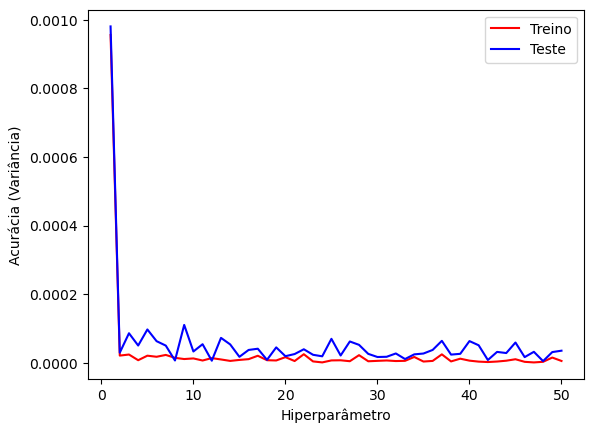

In [24]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Variância)")
pyplot.plot(numpy.arange(1, 51, 1), rf1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), rf2_var, "b-", label="Teste")
pyplot.legend()
pyplot.show()

<p>Como observado graficamente, o modelo sempre tenta evitar o estado de <em>overfitting</em> e controlar a variância, visto que a partir de aproximadamente 6 árvores s curvas de acurácia média de treino e teste se comportam de forma parecida e se mantendo entre intervalos bem definidos. Apesar da variância em teste ter tido picos, ainda sim se manteve com valores baixos, a partir de 10 árvores com valores menores que 0,0001. O número ideal de árvores seria algo próximo de 18, onde a média de acurácias em teste está próxima de 96% e em treino menor que 97%, e a variância em teste está bem próxima do treino, com valores próximos de 0,000125.</p>

# Gradient Tree Boosting

<p>O quinto e último modelo a ser avaliado é o <em>Gradient Tree Boosting</em>, uma técnica de <em>boosting</em> que consiste em utilizar árvores de decisão de tamanho fixo onde a função de perda usada na geração incremental utiliza gradiente. O número de iterações do algoritmo depende da quantidade de árvores geradas, e esse será o hiperparâmetro a ser testado, qual a quatidade ótima a ser utilizada. Vamos também avaliar duas implementações diferentes desse modelo, <b>XGBClassifier</b> da biblioteca <em>XGBoost</em> e <b>GradientBoostingClassifier</b> da biblioteca <em>sklearn</em>.</p>

## GradientBoostingClassifier

<p>Proveniente da biblioteca <em>sklearn</em>, esse algoritmo de classificação gera árvores de regressão sequencialmente usando uma função de perda binomial ou multinomial.</p>

In [25]:
def gradient_tree_boosting(x_train, y_train, x_test, y_test, p):
    gtb = ensemble.GradientBoostingClassifier(n_estimators=p)
    gtb.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, gtb.predict(x_train)), metrics.accuracy_score(y_test, gtb.predict(x_test)))

In [26]:
gtb1_mean, gtb1_var, gtb2_mean, gtb2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(gradient_tree_boosting, sets, x, y, i)
    gtb1_mean.append(numpy.mean(a1))
    gtb1_var.append(numpy.var(a1))
    gtb2_mean.append(numpy.mean(a2))
    gtb2_var.append(numpy.var(a2))

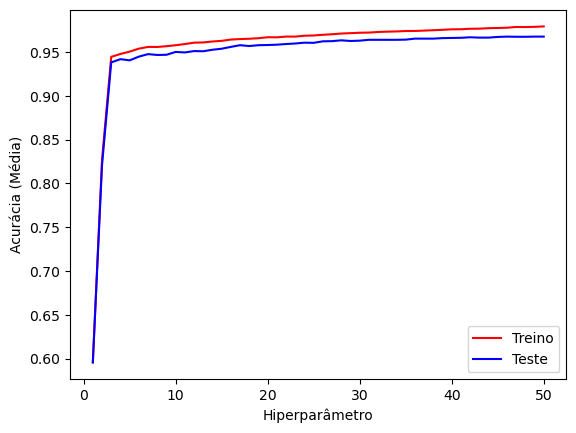

In [27]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Média)")
pyplot.plot(numpy.arange(1, 51, 1), gtb1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), gtb2_mean, "b-", label="Teste")
pyplot.legend()
pyplot.show()

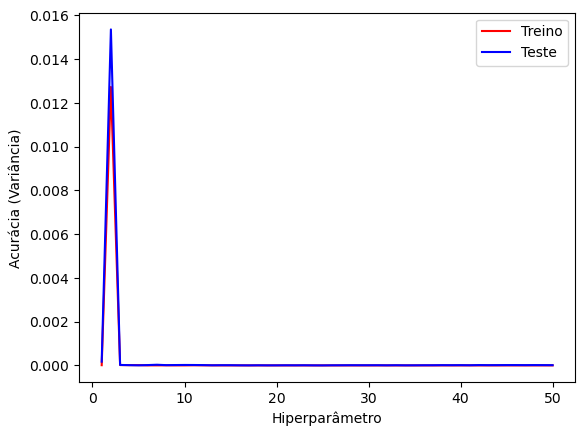

In [28]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Variância)")
pyplot.plot(numpy.arange(1, 51, 1), gtb1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), gtb2_var, "b-", label="Teste")
pyplot.legend()
pyplot.show()

<p>Como observado, esse algorimo é extremamente resistente a <em>overfitting</em>, e apresenta resultados impressionantes tanto em acurácia média como em variância. Entretanto, é possível perceber que a partir de 20 árvores o ganho em acurácia é praticamente nulo, onode os valores de treino e teste estagnaram por volta de 95%.</p>

## XGBClassifier

<p>Proveniente da biblioteca <em>xgboost</em>, esse algoritmo assim como outros de <em>boosting</em> da mesma são implementados com foco em performance (tanto em relação a tempo como espaço) apresentando suporte a paralelismo, portabilidade e flexibilidade.</p>

In [29]:
def xgb_tree(x_train, y_train, x_test, y_test, p):
    xgb = xgboost.sklearn.XGBClassifier(n_jobs=4, n_estimators=p)
    xgb.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, xgb.predict(x_train)), metrics.accuracy_score(y_test, xgb.predict(x_test)))

In [30]:
xgb1_mean, xgb1_var, xgb2_mean, xgb2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(xgb_tree, sets, x, y, i)
    xgb1_mean.append(numpy.mean(a1))
    xgb1_var.append(numpy.var(a1))
    xgb2_mean.append(numpy.mean(a2))
    xgb2_var.append(numpy.var(a2))

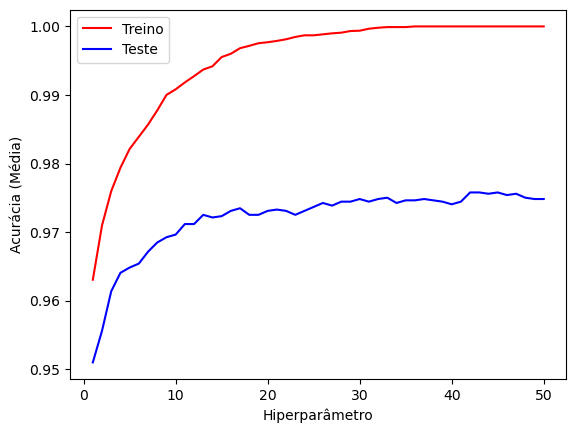

In [31]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Média)")
pyplot.plot(numpy.arange(1, 51, 1), xgb1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), xgb2_mean, "b-", label="Teste")
pyplot.legend()
pyplot.show()

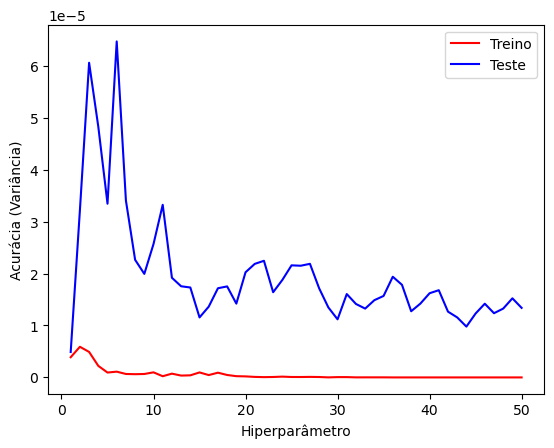

In [32]:
pyplot.xlabel("Hiperparâmetro")
pyplot.ylabel("Acurácia (Variância)")
pyplot.plot(numpy.arange(1, 51, 1), xgb1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), xgb2_var, "b-", label="Teste")
pyplot.legend()
pyplot.show()

<p>Apesar de se apresentar um pouco menos resistente a <em>overfitting</em>, é possível observar que o modelo gerado pelo <b>XGBClassifier</b> apresenta melhores resultados em médias de acurácias, apresentando resultados nos testes acima de 96%, apesar de possuir maior variância (mesmo que sejam valores muito pequenos). O valor ideal seria 30, onde a variância tanto do teste como treino estão muito próximas de 0, e as acurácias de teste e treino a partir de 30 apresentam pouco ganho.</p>

# Comparação Entre Modelos

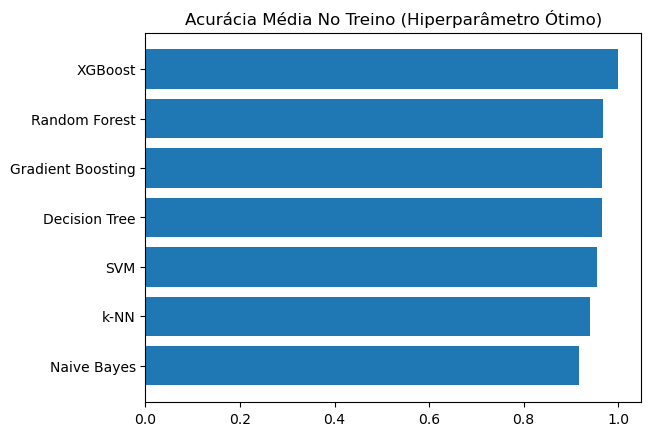

In [33]:
model_names = numpy.array(["Naive Bayes", "Decision Tree", "SVM", "k-NN", "Random Forest", "Gradient Boosting", "XGBoost"])
train_best = numpy.array([numpy.mean(g1), t1_mean[4], s1_mean[0], k1_mean[3], rf1_mean[17], gtb1_mean[19], xgb1_mean[29]])
model_names_train = model_names[numpy.argsort(train_best)]
train_best = numpy.sort(train_best)
pyplot.barh(model_names_train, train_best)
pyplot.title("Acurácia Média No Treino (Hiperparâmetro Ótimo)")
pyplot.show()

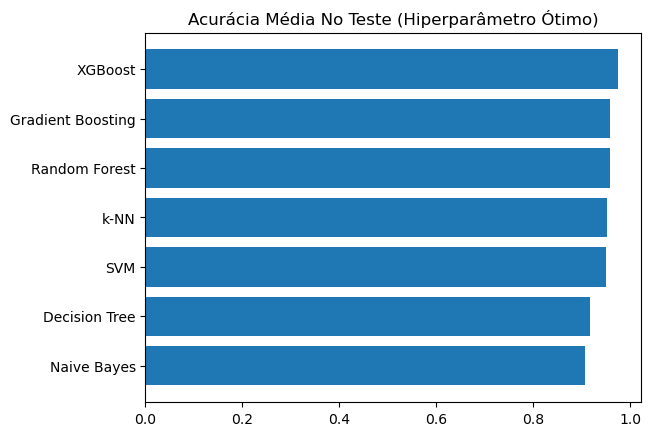

In [34]:
test_best = numpy.array([numpy.mean(g2), t2_mean[4], s2_mean[0], k2_mean[3], rf2_mean[17], gtb2_mean[19], xgb2_mean[29]])
model_names_test = model_names[numpy.argsort(test_best)]
test_best = numpy.sort(test_best)
pyplot.barh(model_names, test_best)
pyplot.title("Acurácia Média No Teste (Hiperparâmetro Ótimo)")
pyplot.show()

In [35]:
pandas.DataFrame({"Hiperparâmetro": [None, 5, "Linear", 4, 18, 20, 30]}).set_index(model_names)

,Hiperparâmetro
Naive Bayes,None
Decision Tree,5
SVM,Linear
k-NN,4
Random Forest,18
Gradient Boosting,20
XGBoost,30


<p>Como é possível observar com os gráficos acima, os modelos <i>XGBoost</i>, <i>Gradient Boosting (sklearn)</i> e <i>Random Forest</i> obtiveram os melhores resultados tanto em teste como em treino, onde <i>XGBoost</i> foi o que se saiu melhor.</p>

## Curvas ROC

<p>Considerando que usamos o método de <i>K-Fold</i> para validação cruzada de tamanho 5, serão apresentadas 5 curvas ROC para cada modelo com seu hiperparâmetro ótimo. Para as métricas de <i>precision</i> e <i>recall</i> foram escolhidos arbitrariamente os primeiros conjuntos definidos no <i>K-Fold</i>.</p>

In [36]:
def predict_and_probabilities(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    return (model.predict(x_test), model.predict_proba(x_test)[:, 1])

In [37]:
def cross_validation_pt_pb(model, sets, x, y):
    y_pt, y_pb = [], []
    for train_set, test_set in sets:
        x_train, y_train = x.iloc[train_set], y.iloc[train_set]
        x_test, y_test = x.iloc[test_set], y.iloc[test_set]
        a1, a2 = predict_and_probabilities(model, x_train, y_train, x_test)
        y_pt.append(a1)
        y_pb.append(a2)
    return (y_pt, y_pb)

In [42]:
def roc_plot(sets, y, y2):
    for i in range(5):
        fpr, tpr, thresholds = metrics.roc_curve(y.iloc[sets[i][1]], y2[i])
        pyplot.plot(fpr, tpr, color="purple")
    pyplot.plot([0, 1], [0, 1], "k--")
    pyplot.xlabel("Taxa De Falsos Positivos")
    pyplot.ylabel("Taxa De Positivos Verdadeiros")
    pyplot.show()

### Naive Bayes

In [43]:
y1, y2 = cross_validation_pt_pb(naive_bayes.GaussianNB(), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.88      0.98      0.93       567
         Yes       0.98      0.84      0.91       474

    accuracy                           0.92      1041
   macro avg       0.93      0.91      0.92      1041
weighted avg       0.93      0.92      0.92      1041



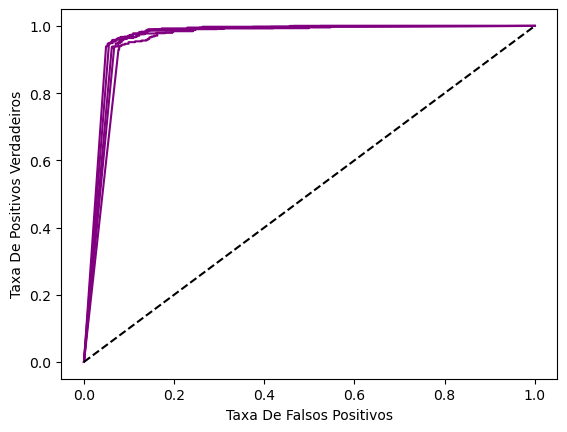

In [44]:
roc_plot(sets, y, y2)

### Decision Tree

In [45]:
y1, y2 = cross_validation_pt_pb(tree.DecisionTreeClassifier(max_depth=5), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.93      0.98      0.95       600
         Yes       0.97      0.90      0.93       441

    accuracy                           0.95      1041
   macro avg       0.95      0.94      0.94      1041
weighted avg       0.95      0.95      0.95      1041



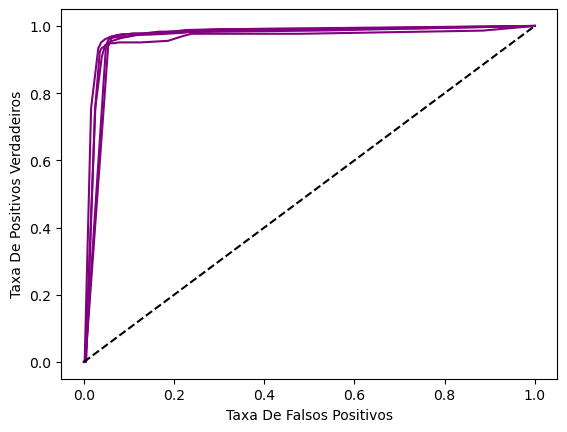

In [46]:
roc_plot(sets, y, y2)

### SVM

In [47]:
y1, y2 = cross_validation_pt_pb(svm.SVC(kernel="linear", probability=True), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.95      0.98      0.96       615
         Yes       0.96      0.92      0.94       426

    accuracy                           0.95      1041
   macro avg       0.96      0.95      0.95      1041
weighted avg       0.96      0.95      0.95      1041



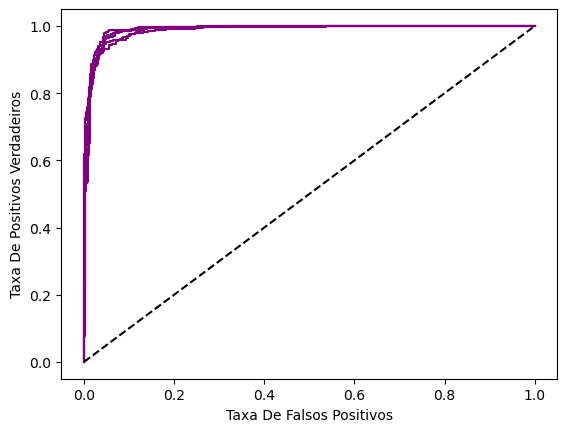

In [48]:
roc_plot(sets, y, y2)

### k-NN

In [49]:
y1, y2 = cross_validation_pt_pb(neighbors.KNeighborsClassifier(n_neighbors=4), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.89      0.95      0.92       589
         Yes       0.93      0.84      0.89       452

    accuracy                           0.90      1041
   macro avg       0.91      0.90      0.90      1041
weighted avg       0.91      0.90      0.90      1041



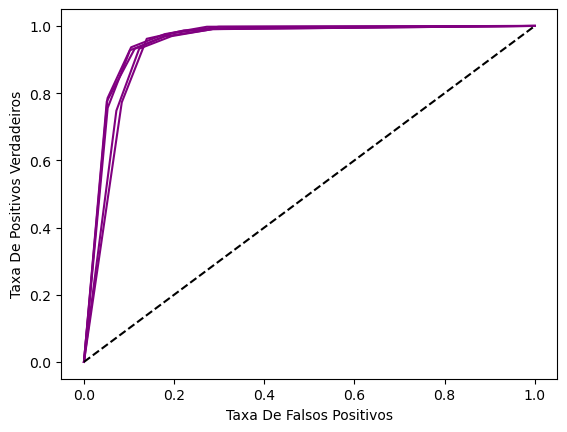

In [50]:
roc_plot(sets, y, y2)

### Random Forest

In [51]:
y1, y2 = cross_validation_pt_pb(ensemble.RandomForestClassifier(max_depth=5, n_estimators=18), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.94      0.97      0.96       612
         Yes       0.96      0.91      0.94       429

    accuracy                           0.95      1041
   macro avg       0.95      0.94      0.95      1041
weighted avg       0.95      0.95      0.95      1041



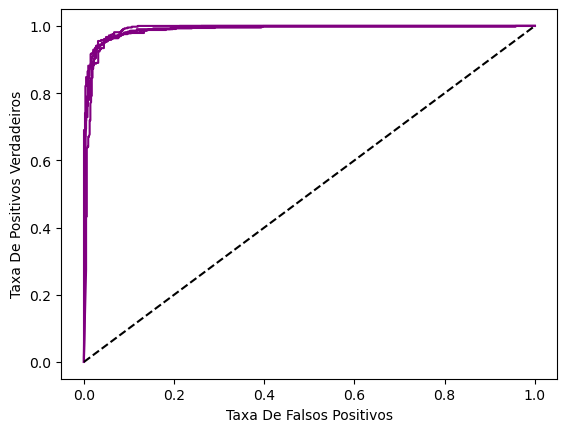

In [52]:
roc_plot(sets, y, y2)

### Gradient Boosting

In [53]:
y1, y2 = cross_validation_pt_pb(ensemble.GradientBoostingClassifier(n_estimators=20), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.95      0.97      0.96       619
         Yes       0.96      0.93      0.95       422

    accuracy                           0.96      1041
   macro avg       0.96      0.95      0.95      1041
weighted avg       0.96      0.96      0.96      1041



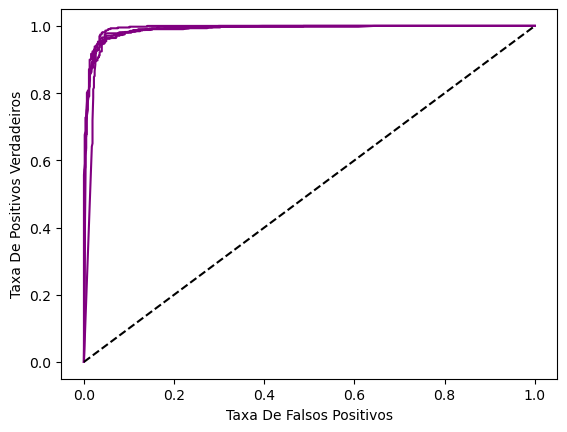

In [54]:
roc_plot(sets, y, y2)

### XGBoost

In [55]:
y1, y2 = cross_validation_pt_pb(xgboost.sklearn.XGBClassifier(n_jobs=4, n_estimators=30), sets, x, y)
print(metrics.classification_report(y1[0], y.iloc[sets[0][1]], labels=[0, 1], target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.97      0.98      0.98       625
         Yes       0.97      0.96      0.96       416

    accuracy                           0.97      1041
   macro avg       0.97      0.97      0.97      1041
weighted avg       0.97      0.97      0.97      1041



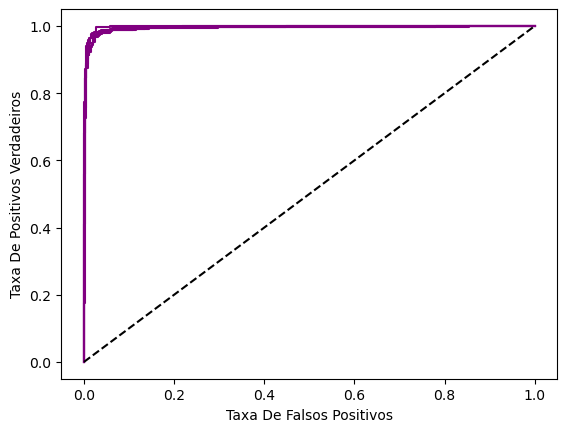

In [56]:
roc_plot(sets, y, y2)

# Conclusão

<p>Ao final deste trabalho prático é possível concluir que <i>K-Fold</i> é uma técnica muito útil para realizar validação cruzada de modelos gerados por algoritmos de aprendizado supervisionado e para encontrar hiperparâmetros ideais para cada algoritmo. Também foi possível perceber que diferentes algoritmos requerem diferentes buscas por hiperparâmetros ideais o que pode interferir muito na acurácia tanto em teste como em treino. Um outro ponto importante foi a diferença na acurácia entre algoritmos comuns e aqueles baseados em <i>boosting</i>, que geralmente apresentaram melhor performance.</p>